In [2]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow", # For OpenAI's pretrained weights
        "pandas"      # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
numpy version: 1.26.3
tiktoken version: 0.8.0
torch version: 2.5.1+cpu
tensorflow version: 2.18.0
pandas version: 2.2.3


## 6.2 准备数据集

In [3]:
# 下载数据集
import urllib.request
import zipfile
import os
from pathlib import Path
import pandas as pd

os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # 下载文件
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # 解压文件
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # 添加 .tsv 文件扩展
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")


download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
display(df.head())
print(df["Label"].value_counts())


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Label
ham     4825
spam     747
Name: count, dtype: int64


In [4]:
# 让数量相等，因为ham比spam多很多
def create_balenced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0] 
    #随机选取
    ham_subset = df[df["Label"] == "ham"].sample(num_spam,random_state=123)

    balanced_df = pd.concat([ham_subset,df[df["Label"] == "spam"]])
    
    return balanced_df


balanced_df =  create_balenced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [5]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1,1:1,0:0})

def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # 利用索引来切割
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df



train_df , validation_df , test_df = random_split(balanced_df,0.7,0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## 6.3 创建数据加载器

In [6]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [7]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # 预标记文本
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # 如果序列长于 max_length，则截断序列
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # 将序列填充到最长序列
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [8]:
from torch.utils.data import DataLoader

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer,
)
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer,
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer,
)
# print(train_dataset.__len__())
# print(val_dataset.__len__())
# print(test_dataset.__len__())

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)


print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)


print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Train loader:


Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
19 validation batches
38 test batches


## 6.4 使用预训练权重初始化模型

In [ ]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,  # Dropout rate
    "qkv_bias": True,  # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()




File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [13]:
###测试模型是否正常运行

from previous_chapters import generate_text_simple, text_to_token_ids, token_ids_to_text


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

### 测试模型的指令遵循能力
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
    " Answer with 'yes' or 'no'."
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))


print(model)

Every effort moves you forward.

The first step is to understand the importance of your work
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' Answer with 'yes' or 'no'. Answer with 'yes' or 'no'. Answer with 'yes' or 'no'. Answer with 'yes'
GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_featur

In [20]:
for param in model.parameters():
    param.requires_grad = False
    
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True
    
    
    
# 测试一下输入输出
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # 形状: (batch_size, num_tokens, num_classes)
print("Last output token:", outputs[:, -1, :])# 最后一个标记最重要



probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])
Last output token: tensor([[-3.5983,  3.9902]])
Class label: 1


In [21]:
def calc_accuracy_loader(data_loader,model,device,num_batches=None):
    model.eval()
    correct_predictions,num_examples =  0 , 0
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches,len(data_loader))
    
    for i,(input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch , target_batch = input_batch.to(device),target_batch.to(device)
            
            with torch.no_grad():
                logits = model(input_batch)[:,-1,:]
                
            predicted_label = torch.argmax(logits,dim=-1)
            num_examples += predicted_label.shape[0]
            correct_predictions += (predicted_label == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # nn.Module 类不需要分配 model = model.to(device)

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [23]:
# 定义损失函数
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # 最后输出标记的 Logits
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


# num_batches 指的是计算几组
def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches,len(data_loader))
    
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss  += loss.item()
        else:
            break
        
    return total_loss / num_batches


In [24]:
# 训练前计算损失
with torch.no_grad(): # 禁用梯度跟踪以提高效率，因为我们还没有进行训练
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


In [25]:
# 总体与第5章中的 `train_model_simple` 相同
def train_classifier_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    tokenizer,
):
    # 初始化列表以跟踪损失和看到的示例
    # train_losses用于记录每个评估步骤时训练集上的损失值
    # val_losses用于记录每个评估步骤时验证集上的损失值
    # train_accs用于记录每个训练周期结束后训练集上的准确率
    # val_accs用于记录每个训练周期结束后验证集上的准确率
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    # examples_seen用于统计在训练过程中已经处理过的样本数量，初始化为0
    # global_step用于记录训练过程中的全局步数（每进行一次梯度更新算一步），初始化为 -1
    examples_seen, global_step = 0, -1

    # 主要的训练循环，会按照设定的训练周期数（num_epochs）依次进行每个周期的训练操作
    for epoch in range(num_epochs):
        model.train()  # 将模型设置为训练模式，使得如Dropout、Batch Normalization等层在训练时有相应的正确行为

        # 遍历训练数据加载器（train_loader）中的每一批次数据，
        # 其中input_batch是输入数据，target_batch是对应的目标数据（如标签等）
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # 重置上一个批次计算产生的损失梯度，避免梯度累积影响本次梯度计算
            # 调用calc_loss_batch函数计算当前批次数据对应的损失值，传入输入数据、目标数据、模型以及计算设备等参数
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # 进行反向传播，根据损失函数自动计算损失相对于模型中各参数的梯度，梯度值会存储在相应参数的.grad属性中
            optimizer.step()  # 使用优化器（如SGD、Adam等）依据计算得到的梯度来更新模型的权重等参数，以优化模型
            # 累加当前批次的样本数量到examples_seen中，实现跟踪已处理的样本数量（这里是按样本个数而非标记个数统计）
            examples_seen += input_batch.shape[0]
            global_step += 1

            # 可选的评估步骤，按照设定的评估频率（eval_freq）判断是否进行模型评估
            if global_step % eval_freq == 0:
                # 调用evaluate_model函数对模型在训练集和验证集上进行评估，传入模型、训练数据加载器、验证数据加载器、计算设备以及评估迭代次数等参数
                # 该函数返回当前模型在训练集和验证集上的损失值
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                # 将本次评估得到的训练集损失值添加到train_losses列表中
                train_losses.append(train_loss)
                # 将本次评估得到的验证集损失值添加到val_losses列表中
                val_losses.append(val_loss)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # 计算每个 epoch 结束后模型在训练集上的准确率，调用calc_accuracy_loader函数，指定评估的批次数量为eval_iter
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        # 计算每个 epoch 结束后模型在验证集上的准确率，同样调用calc_accuracy_loader函数，指定评估的批次数量为eval_iter
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        # 将本 epoch 计算得到的训练集准确率添加到train_accs列表中
        train_accs.append(train_accuracy)
        # 将本 epoch 计算得到的验证集准确率添加到val_accs列表中
        val_accs.append(val_accuracy)

    # 返回训练过程中记录的训练集损失值列表、验证集损失值列表、训练集准确率列表、验证集准确率列表以及已处理的总样本数量
    return train_losses, val_losses, train_accs, val_accs, examples_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [27]:
## 微调

import time

start_time = time.time()
torch.manual_seed(123)
num_epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5,
    tokenizer=tokenizer,
)


end_time = time.time()

execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 0.125, Val loss 0.063
Ep 1 (Step 000050): Train loss 0.048, Val loss 0.104
Ep 1 (Step 000100): Train loss 0.154, Val loss 0.062
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 2 (Step 000150): Train loss 0.083, Val loss 0.091
Ep 2 (Step 000200): Train loss 0.017, Val loss 0.056
Ep 2 (Step 000250): Train loss 0.022, Val loss 0.091
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.103, Val loss 0.138
Ep 3 (Step 000350): Train loss 0.013, Val loss 0.071
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.015, Val loss 0.078
Ep 4 (Step 000450): Train loss 0.047, Val loss 0.095
Ep 4 (Step 000500): Train loss 0.127, Val loss 0.077
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.090, Val loss 0.096
Ep 5 (Step 000600): Train loss 0.018, Val loss 0.060
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 10.01 m

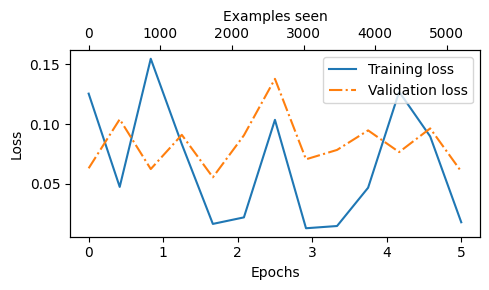

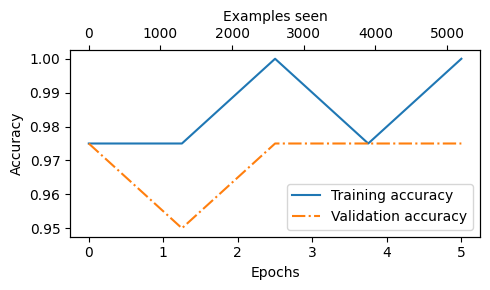

In [33]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 绘制针对 epoch 的训练和验证损失
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # 为所见示例创建第二个 x 轴
    ax2 = ax1.twiny()  # 创建共享相同 y 轴的第二个 x 轴
    ax2.plot(examples_seen, train_values, alpha=0)  # 用于对齐刻度的不可见图
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # 调整布局以腾出空间
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
    
    
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)


epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [34]:
# 对训练完的模型进行测试
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.85%
Validation accuracy: 97.32%
Test accuracy: 97.33%


## 6.8 使用大模型作为垃圾邮件分类器

In [36]:
def classify_review(
    text, model, tokenizer, device, max_length=None, pad_token_id=50256
):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[: min(max_length, supported_context_length)]
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)  # 添加批次维度
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # 最后一个输出 token 的 Logits
    predicted_label = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_label == 1 else "not spam"


text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))


text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

spam
not spam


In [37]:
torch.save(model.state_dict(), "review_classifier.pth")
